### Exploratory Analysis: Using Sklearn's SVM on the MNIST dataset, and explaining the results with LIME

 Code in this file has been adapted from the offical LIME tutorial for image classifiers using Random Forests for Support Vector Machines (SVMs): https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20MNIST%20and%20RF.ipynb



### 0. Importing most of the necessary libraries

In [161]:
import os
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
# since the ImageExplanation(image, segments) wants 3D numpy arrays (colour images) for segments
from skimage.color import gray2rgb, rgb2gray, label2rgb

### 1. Dynamically Loading the dataset from the provided mnist-original.mat file

In [194]:
# 1: Load training data for image classification.
root_directory = 'ExplainabilityTool'
abcrot_pat = os.path.abspath#(root_directory)
print(f"root_path {root_path}")
datasets_directory = 'Datasets'
# target_directory = os.path.join(root_path, datasets_directory)
target_file = 'mnist-original.mat'

# Walk through the directory tree rooted at the target directory
for dirpath, dirnames, filenames in os.walk(root_directory):
    print(f"file names: {filenames}")
    if target_file in filenames:
        file_path = os.path.join(dirpath, target_file)
        print(f"File path: {file_path}")
        break
print(f"File path: {file_path}")


root_path c:\Users\space\OneDrive\Desktop\p4p\ExplainabilityTool\PythonScripts\ExplainabilityTool
File path: 


In [163]:
mnist = loadmat(r"C:\Users\space\OneDrive\Desktop\p4p\ExplainabilityTool\Datasets\MNIST\mnist-original.mat")
# df = pd.DataFrame(mnist)
# print(mnist)

In [164]:
keys = mnist.keys()
print(f"keys: {keys}")

print("MNIST DATA")
data = mnist["data"].T
label = mnist["label"].T
print(data)
print(type(data))
print(np.shape(data))

print("MNIST LABEL")
print(label)
print(type(label))
print(np.shape(label))

keys: dict_keys(['__header__', '__version__', '__globals__', 'mldata_descr_ordering', 'data', 'label'])
MNIST DATA
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(70000, 784)
MNIST LABEL
[[0.]
 [0.]
 [0.]
 ...
 [9.]
 [9.]
 [9.]]
<class 'numpy.ndarray'>
(70000, 1)


(70000, 28, 28, 3)


Text(0.5, 1.0, 'Digit: 0')

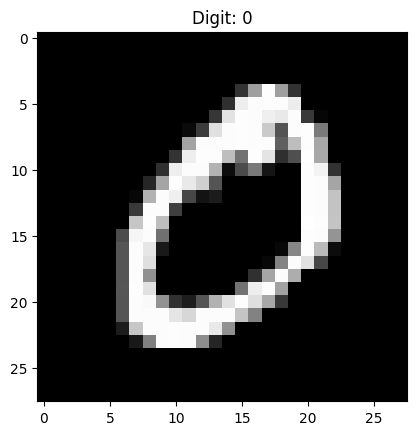

In [165]:
%matplotlib inline
data = np.stack([gray2rgb(iimg)
                 for iimg in data.reshape((-1, 28, 28))], 0).astype(np.uint8)
label = label.astype(np.uint8)

print(np.shape(data))

fig, ax1 = plt.subplots(1, 1)
ax1.imshow(data[0], interpolation="none") 
ax1.set_title(f"Digit: {label[0][0]}" )

In [174]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)



makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

pipe = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('svc', SVC(probability=True))]) # SVC uses default params found here https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

print(np.shape(data))
print(np.shape(label))

x_train, x_test, y_train, y_test = train_test_split(data, np.ravel(label), train_size=0.65)



(70000, 28, 28, 3)
(70000, 1)


In [175]:
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)


0.9770204081632653

In [176]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [177]:
%%time
explanation = explainer.explain_instance(x_test[0], 
                                         classifier_fn = pipe.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 45 s
Wall time: 1min 9s


Text(0.5, 1.0, 'Positive/Negative Regions for 3')

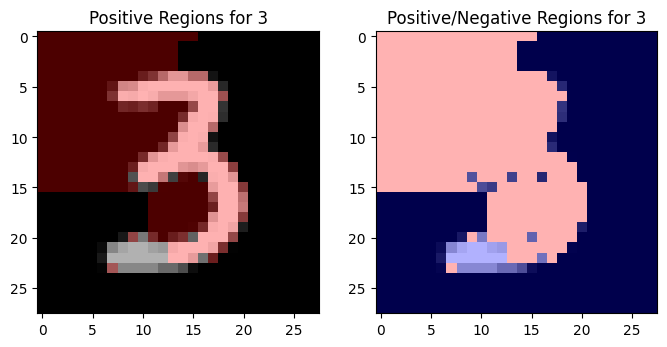

In [178]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

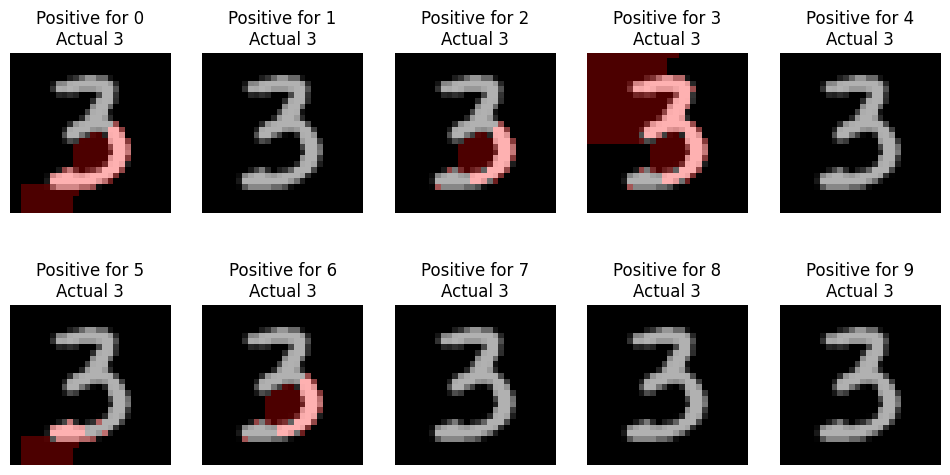

In [180]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,x_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

In [183]:
pipe_pred_test = pipe.predict(x_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #16767 where the label was 7 and the pipeline predicted 9


In [185]:
%%time
explanation = explainer.explain_instance(x_test[wrong_idx], 
                                         classifier_fn = pipe.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 50.3 s
Wall time: 1min 4s


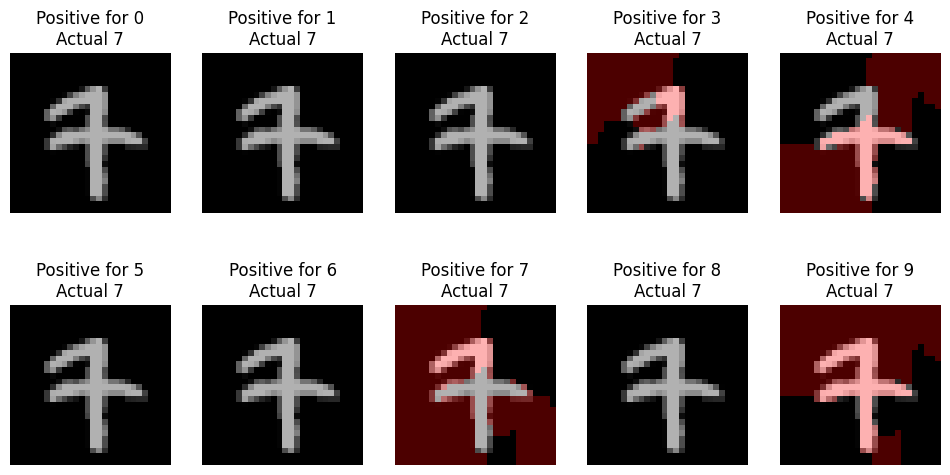

In [186]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')